<h1><center>Analysis of Life Expectancy Data</center></h1>
<h3><center>Evan Nadelbach and Joseph Zietowski</center></h3>

### Importance of Global Health
The world's ongoing fight against Covid-19 makes it very clear that global health is of the utmost importance for the future of humanity, and as the world continues to become more and more physically connected, the importance of global health will continue to skyrocket. It is a misconception that global health doesn't affect everyone, especially those already living in "healthy" countries with access to good education and medicine. Global health is often described as a security issue, but it is also a political issue and even an economic issue. Ultimately, due to how fast diseases and ideas can spread, global health quickly turns into everyone’s issue. Improving global health and the well-being of all people is no easy task due to the extensive variation among populations, but, just like in any other complicated question, narrowing down the fundamental problem can help bring to light the real factors in play. In order make the problem as specific as possible, it is necessary to break it into smaller, easier problems that pertain to specific populations. To do this, we must first understand how to measure global health, and although there are countless factors, life expectancy is a great place to start due to its objectiveness and universality.

### What is life expectancy?
Life expectancy statistics may seem self-explanatory, but there are actually many different ways of measuring life expectancy, and some of them are more biased more than others. Life expectancy at birth (LEB) is the measure we decided to use for this project. The world health organization defines <a href="https://www.who.int/data/gho/indicator-metadata-registry/imr-details/65">LEB</a> as "the average number of years that a newborn could expect to live, if he or she were to pass through life exposed to the sex- and age-specific death rates prevailing at the time of his or her birth, for a specific year, in a given country, territory, or geographic area." We could have chosen another measure such as life expectancy at age 60 or healthy life expectancy at birth/age 60, but since we are more concerned with general trends and comparing life expectancies between populations than with the actual number of years, we chose a very basic statistic. It is also important to understand that since we want to look at data from recent years, the true/<i>Cohort</i> life expectancy can't be computed for people born in those years since not all of them have died. Consequently, the life expectancy data we are using is actually called <i>Period</i> LEB, which uses true/<i>Cohort</i> life expectancies from the past to predict the average life expectancy for a person born in a recent year. More information about the different measures of life expectancy can be found <a href="https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/lifeexpectancies/methodologies/periodandcohortlifeexpectancyexplained">here</a>.

### Purpose
The purpose of this tutorial is to analyze many factors that contribute either positively/negatively to life expectancy in populations around the world so that we can get a better understanding of which factors should be focused on the most in order to increase the well-being of people around the world. Data science is a perfect tool for this job because it allows us to break up the complicated data into understandable advice that can be put into action.

<h2>Data Collection and Imputation</h2>

All the data we are using comes from the <a href="https://www.who.int/">World Health Organization</a>, a United Nations agency that specializes in international public health. We decided to choose a wide variety of factors that may contribute to life expectancy and global health. After importing life expectancy and 10 other features, our dataset will have 183 countries from 2000-2016 (3111 rows), and 11 features for each row (including life expectancy). One problem is that not all of the features contain all 183 countries and all 17 years. To account for this, we will use linear regression to predict the values for each missing year in each feature dataset. There usually isn't much missing data like this, so we don't suspect this will introduce substantial bias. On the other hand, most of the missing data is due to the feature datasets not having all the 183 countries. We will come back to this problem later.

In [1]:
!pip install plotly

In [2]:
# data collection
import numpy as np
import pandas as pd
import re

# plotting graphs and the map of every country
import matplotlib.pyplot as plt
import plotly.express as px

# machine learning and filling in missing data
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# hypothesis testing
import statsmodels.formula.api as smf

# to display images
from IPython.display import Image

pd.set_option('display.max_rows', None)

### Add the life expectancy <a href="https://apps.who.int/gho/data/view.main.SDG2016LEXv?lang=en">data</a> (<i>Period</i> Life expectancy at birth)
Our first step is to import our life expectancy data and get rid of the measures we aren't going to use. The life expectancy table includes data that separates life expectancy by sex, and for each one, it lists life expectancy from birth and from age 60. We are considering only the life expectancy at birth for both sexes combined (taken as an average of both sexes individually).

In [3]:
# read in the life expectancy data
df = pd.read_csv("data/life_expectancy.csv")

# remove the unwanted columns
df = df[["Country", "Year", "Life expectancy at birth (years) (Both sexes)"]]

# rename the columns
df = df.rename(columns={"Life expectancy at birth (years) (Both sexes)": "life_expectancy", \
                        "Country" : "country", "Year" : "year"})

# remove the rows that are not needed (year > 2016)
df.drop(df[df.year >= 2017].index, inplace=True)

df.head()

,country,year,life_expectancy
0,Afghanistan,2016,62.7
1,Afghanistan,2015,63.2
2,Afghanistan,2014,63.0
3,Afghanistan,2013,62.7
4,Afghanistan,2012,62.2


### Add the BMI <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/mean-bmi-(kg-m-)-(age-standardized-estimate)">data</a> (Age-standardized mean BMI (kg/m^2) 18+ years old)
For the BMI data, there is a small amount of missing data, so we filled it with the average BMI for that year. Since there was such a small amount of missing data, and BMIs seem fairly consistent between countries, we dont think this will introduce any noticible bias.

In [4]:
# read in the data
bmi = pd.read_csv("data/bmi.csv")

# drop the unwanted columns
bmi.drop('Indicator',axis=1,inplace=True)
bmi.drop('Dim2',axis=1,inplace=True)

# drop the unwanted rows
bmi.drop(bmi[bmi.Period < 2000].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Male"].index, inplace=True)
bmi.drop(bmi[bmi.Dim1 == "Female"].index, inplace=True)

# tidy the data in the bmi column
bmi["First Tooltip"].replace(["No data"], np.nan, inplace=True)
bmi["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
bmi["First Tooltip"] = bmi["First Tooltip"].astype(float)

# get the mean bmi
bmi_mean = round(bmi.groupby('Period', as_index=False)['First Tooltip'].mean(), 1)

# merge the data into our life expectancy dataframe
df = df.merge(bmi, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)
df.drop('Dim1', axis=1, inplace=True)

# rename the BMI column
df = df.rename(columns={"First Tooltip": "bmi"})

# mean imputation
for index, row in df.iterrows():
    if (str(row['bmi']) == "nan"):
        df.at[index, 'bmi'] = bmi_mean.loc[bmi_mean['Period'] == row['year']]['First Tooltip']
        
df.head()

,country,year,life_expectancy,bmi
0,Afghanistan,2016,62.7,23.4
1,Afghanistan,2015,63.2,23.3
2,Afghanistan,2014,63.0,23.2
3,Afghanistan,2013,62.7,23.0
4,Afghanistan,2012,62.2,22.9


### Add the drinking-water <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/population-using-safely-managed-drinking-water-services-(-)">data</a> (% of population using at least basic drinking-water services)
For the drinking water data, we will use linear regression to fill in the data for the very few instances of missing years. If you want to learn more about how we did this, look <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">here</a>. 

In [5]:
# read in the data
drinking_water = pd.read_csv("data/drinking_water.csv")

# drop unwanted rows
indicator = "Population using at least basic drinking-water services (%)"
drinking_water.drop(drinking_water[drinking_water.Indicator != indicator].index, inplace=True)

# drop unwanted columns
drinking_water.drop("Indicator", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in drinking_water['Location'].unique():
    
    # get only the data for the current country
    currdata = drinking_water.loc[drinking_water['Location'] == i]

    # linear regression will have the year (Period) as the predictors and the drinking water percentage (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            drinking_water = drinking_water.append({'Location': i, 'Period': k, \
                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(drinking_water, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the drinking water column
df = df.rename(columns={"First Tooltip": "drinking_water"})

df.head()

,country,year,life_expectancy,bmi,drinking_water
0,Afghanistan,2016,62.7,23.4,54.84
1,Afghanistan,2015,63.2,23.3,52.39
2,Afghanistan,2014,63.0,23.2,49.96
3,Afghanistan,2013,62.7,23.0,47.56
4,Afghanistan,2012,62.2,22.9,45.19


### Add the government expenditure <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/general-government-expenditure-on-health-as-a-percentage-of-total-government-expenditure">data</a> (% of government expenditure on general health)
For the government expenditure data, we will once again use linear regression to fill in the data for the missing years.

In [6]:
# read in the data
government_expenditure = pd.read_csv("data/government_expenditure.csv")

# drop unwanted columns
government_expenditure.drop("Indicator", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in government_expenditure['Location'].unique():
    
    # get only the data for the current country
    currdata = government_expenditure.loc[government_expenditure['Location'] == i]
    
    # linear regression will have the year (Period) as the predictors and the government expenditure
    # percentage (First Tooltip) as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            government_expenditure = government_expenditure.append({'Location': i, \
                                                                    'Period': k, \
                                                                    'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                                                   ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(government_expenditure, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the government expenditure column
df = df.rename(columns={"First Tooltip": "government_expenditure"})

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure
0,Afghanistan,2016,62.7,23.4,54.84,13.31
1,Afghanistan,2015,63.2,23.3,52.39,12.75
2,Afghanistan,2014,63.0,23.2,49.96,12.00
3,Afghanistan,2013,62.7,23.0,47.56,10.59
4,Afghanistan,2012,62.2,22.9,45.19,11.67


### Add the hospital beds <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/hospital-beds-(per-10-000-population)">data</a> (Number of hospital beds available per 10,000 population)
Import the hospital beds data and use linear regression to fill in data for the missing years.

In [7]:
# read in the data
hospital_beds = pd.read_csv("data/hospital_beds.csv")

# drop unwanted columns
hospital_beds.drop("Indicator", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in hospital_beds['Location'].unique():
    
    # get only the data for the current country
    currdata = hospital_beds.loc[hospital_beds['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the hospital bed data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to one decimal place
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            hospital_beds = hospital_beds.append({'Location': i, 'Period': k, \
                                                  'First Tooltip': round(reg.predict([[k]])[0], 1)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(hospital_beds, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the hospital beds column
df = df.rename(columns={"First Tooltip": "hospital_beds"})

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3


### Add the homicide <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/estimates-of-rates-of-homicides-per-100-000-population">data</a> (Estimates of rates of homicides per 100,000 population)
Import the homicide data and use linear regression to fill in data for the missing years.

In [8]:
# read in the data
homicides = pd.read_csv("data/homicides.csv")

# drop unwanted rows
homicides.drop(homicides[homicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
homicides.drop("Indicator", axis=1, inplace=True)
homicides.drop("Dim1", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in homicides['Location'].unique():
    
    # get only the data for the current country
    currdata = homicides.loc[homicides['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the homicide data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            homicides = homicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(homicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the homicides column
df = df.rename(columns={"First Tooltip": "homicides"})

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80


### Add the malaria <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/malaria-incidence-(per-1-000-population-at-risk)">data</a> (Malaria incidence per 1,000 population at risk)
For the malaria data, many countries in the world have very little or no cases of malaria due to the climate. These countries were not included in the dataset, so we can add them manually and assume that the incidence is 0. We stil want to do linear regression on the countries with missing years though. It turns out that malaria varies greatly between countries due to the climate and how developed that country is. It will be interesting to see how this plays into our analysis.

In [9]:
# read in the data
malaria = pd.read_csv("data/malaria.csv")

# drop unwanted columns
malaria.drop("Indicator", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in malaria['Location'].unique():
    
    # get only the data for the current country
    currdata = malaria.loc[malaria['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the malaria data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            malaria = malaria.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(malaria, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the malaria column
df = df.rename(columns={"First Tooltip": "malaria"})

# fill in any countries that are missing malaria data for every year with 0
df["malaria"].fillna(0, inplace=True)

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15


### Add the pollution <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/gho-phe-primary-reliance-on-clean-fuels-and-technologies-proportion">data</a> (% of population with primary reliance on clean fuels and technologies)
Import the pollution data and use linear regression to fill in data for the missing years.

In [10]:
# read in the data
pollution = pd.read_csv("data/pollution.csv")

# drop unwanted columns
pollution.drop("Indicator", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in pollution['Location'].unique():
    
    # get only the data for the current country
    currdata = pollution.loc[pollution['Location'] == i]

    # Linear regression will have the Year (Period) as the predictors and the pollution percentage (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            pollution = pollution.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(pollution, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the pollution column
df = df.rename(columns={"First Tooltip": "pollution"})

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11,31.0
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91,29.0
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67,27.0
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01,25.0
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15,23.0


### Add the suicide <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/age-standardized-suicide-rates-(per-100-000-population)">data</a> (Age-standardized suicide rates per 100,000 population)
Import the suicide data and use linear regression to fill in data for the missing years.

In [11]:
# read in the data
suicides = pd.read_csv("data/suicide.csv")

# drop unwanted rows
suicides.drop(suicides[suicides.Dim1 != "Both sexes"].index, inplace=True)

# drop unwanted columns
suicides.drop("Indicator", axis=1, inplace=True)
suicides.drop("Dim1", axis=1, inplace=True)

# this loop will iterate for each country in the dataset
for i in suicides['Location'].unique():
    
    # get only the data for the current country
    currdata = suicides.loc[suicides['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the suicide data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            suicides = suicides.append({'Location': i, 'Period': k, 'First Tooltip': round(reg.predict([[k]])[0], 1)}, \
                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(suicides, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the suicides column
df = df.rename(columns={"First Tooltip": "suicides"})

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9


### Add the tuberculosis <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/deaths-due-to-tuberculosis-among-hiv-negative-people-(per-100-000-population)">data</a> (Deaths due to tuberculosis among HIV-negative people per 100,000 population)
Import the tuberculosis data and use linear regression to fill in data for the missing years.

In [12]:
# read in the data
tuberculosis = pd.read_csv("data/tuberculosis.csv")

# drop unwanted column
tuberculosis.drop("Indicator", axis=1, inplace=True)

# tidy the data in the tuberculosis column
tuberculosis["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
tuberculosis["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# this loop will iterate for each country in the dataset
for i in tuberculosis['Location'].unique():
    
    # get only the data for the current country
    currdata = tuberculosis.loc[tuberculosis['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the tuberculosis data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to one decimal place
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            tuberculosis = tuberculosis.append({'Location': i, 'Period': k, \
                                                'First Tooltip': round(reg.predict([[k]])[0], 1)}, ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(tuberculosis, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the tuberculosis column
df = df.rename(columns={"First Tooltip": "tuberculosis"})

# change the column from a string to a float
df['tuberculosis'] = df['tuberculosis'].astype(float)

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0


### Add the under-five deaths <a href="https://www.who.int/data/gho/data/indicators/indicator-details/GHO/under-five-mortality-rate-(probability-of-dying-by-age-5-per-1000-live-births)">data</a> (Probability of a child dying before reaching the age of five)
Import the under-five deaths data and use linear regression to fill in data for the missing years.

In [13]:
# read in the data
under_five_deaths = pd.read_csv("data/under_five_deaths.csv")

# drop unwanted rows
under_five_deaths.drop(under_five_deaths[under_five_deaths.Dim1 != "Both sexes"].index, inplace=True)
indicator = "Infant mortality rate (probability of dying between birth and age 1 per 1000 live births)"
under_five_deaths.drop(under_five_deaths[under_five_deaths.Indicator != indicator].index, inplace=True)

# drop unwanted column
under_five_deaths.drop("Indicator", axis=1, inplace=True)
under_five_deaths.drop("Dim1", axis=1, inplace=True)

# tidy the data in the under_five_deaths column
under_five_deaths["First Tooltip"].replace(["\[.*\]"], "", inplace=True, regex=True)
under_five_deaths["Location"].replace(["Sudan \(until 2011\)"], "Sudan", inplace=True, regex=True)

# this loop will iterate for each country in the dataset
for i in under_five_deaths['Location'].unique():
    
    # get only the data for the current country
    currdata = under_five_deaths.loc[under_five_deaths['Location'] == i]

    # linear regression will have the Year (Period) as the predictors and the under five death data (First Tooltip)
    # as the value
    X = currdata[['Period']]
    y = currdata['First Tooltip']

    # creating the linear regression line
    reg = linear_model.LinearRegression()
    reg.fit(X, y)

    # generate data for countries that have any missing for years 2000-2016, rounded to two decimal places
    for k in range(2000, 2017):
        if not k in currdata['Period'].values:
            under_five_deaths = under_five_deaths.append({'Location': i, \
                                                          'Period': k, \
                                                          'First Tooltip': round(reg.predict([[k]])[0], 2)}, \
                                                         ignore_index=True)

# merge the data into our life expectancy dataframe
df = df.merge(under_five_deaths, how = "left", left_on = ["country", "year"], right_on = ["Location", "Period"])

# remove more unwanted columns
df.drop('Location', axis=1, inplace=True)
df.drop('Period', axis=1, inplace=True)

# rename the under five deaths column
df = df.rename(columns={"First Tooltip": "under_five_deaths"})

# change the column from a string to a float
df['under_five_deaths'] = df['under_five_deaths'].astype(float)

df.head()

,country,year,life_expectancy,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis,under_five_deaths
0,Afghanistan,2016,62.7,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0,51.32
1,Afghanistan,2015,63.2,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0,53.17
2,Afghanistan,2014,63.0,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0,55.16
3,Afghanistan,2013,62.7,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0,57.23
4,Afghanistan,2012,62.2,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0,59.45


In [14]:
# print the data types of the columns
df.dtypes

country                    object
year                        int64
life_expectancy           float64
bmi                       float64
drinking_water            float64
government_expenditure    float64
hospital_beds             float64
homicides                 float64
malaria                   float64
pollution                 float64
suicides                  float64
tuberculosis              float64
under_five_deaths         float64
dtype: object

We have now imported all of the data we will need, but there are missing values. Lets look at the number of missing values in each colum and the total percentage of missing data.

In [15]:
# print the number of missing data points in each column
print(df.isna().sum())

# calculate the percentage of missing data in our dataset
missing_percentage = df.isna().sum().sum() / (len(df) * (len(df.columns) - 1))
print("\nPercent of missing data: " + str(round(missing_percentage * 100, 3)))

country                     0
year                        0
life_expectancy             0
bmi                         0
drinking_water             34
government_expenditure     68
hospital_beds             119
homicides                  34
malaria                     0
pollution                 102
suicides                   34
tuberculosis               51
under_five_deaths          34
dtype: int64

Percent of missing data: 1.275


It seems as though 8 of our 10 additional features have missing data, but we can see that it doesn't add up to much missing data compared to the size of our dataset. Since we already filled in the data for the missing years when adding the features to the dataframe, we know that all of the missing data must be because the feature data doesn't include one or more of the 183 countries. We need to fill in this data so that we can later train a ML model with it, but unlike the very small amount missing data we already filled in, filling in this missing data has the potential to introduce a bias. Even though 1.275 is considered to be a low percentage, it is better to be safe, so we should do something to check the bias we introduce. There is nothing we can do to avoid this bias if we want data for all the countries, but there are some things we can do to reduce it as much as possible.

We decided to use the K-nearest neighbors imputer from sklearn to fill in this data. We found that using 10 neighbors and uniform weights for each point works the best at making good predictions. More documentation about the KNN imputer in sklearn can be found <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html">here</a>.

In [16]:
# save the df before imputation (we can use this later for analyzing the accuracy of the imputation)
df_raw = df

# set up the KNN imputer
imputer = KNNImputer(n_neighbors=10, weights="uniform")

# pass in all the features aside from the country name
dftemp = imputer.fit_transform(df.values[:, 1:])

# turn the predictions into a pandas dataframe and add back the country column
dftemp = pd.DataFrame(dftemp)
dftemp.insert(0, "country", df["country"], True)

# rearrange the columns like they were originally
dftemp.columns = ['country', 'year', 'life_expectancy', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', \
                 'homicides', 'malaria', 'pollution', 'suicides', 'tuberculosis', 'under_five_deaths']

# change the type of the year column to an int
dftemp['year'] = dftemp['year'].astype(int)

# set df to the new imputed dataframe
df = dftemp

# reorder the columns in the dataframe so that life expectancy comes last
df = df[['country', 'year', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', 'homicides', 'malaria', \
        'pollution', 'suicides', 'tuberculosis', 'under_five_deaths', 'life_expectancy']]

df.head()

,country,year,bmi,drinking_water,government_expenditure,hospital_beds,homicides,malaria,pollution,suicides,tuberculosis,under_five_deaths,life_expectancy
0,Afghanistan,2016,23.4,54.84,13.31,5.0,7.40,26.11,31.0,6.4,34.0,51.32,62.7
1,Afghanistan,2015,23.3,52.39,12.75,5.0,7.40,14.91,29.0,6.6,39.0,53.17,63.2
2,Afghanistan,2014,23.2,49.96,12.00,5.0,7.75,12.67,27.0,6.7,43.0,55.16,63.0
3,Afghanistan,2013,23.0,47.56,10.59,5.3,7.77,9.01,25.0,6.8,43.0,57.23,62.7
4,Afghanistan,2012,22.9,45.19,11.67,5.3,7.80,11.15,23.0,6.9,44.0,59.45,62.2


## Data Visualization
It can be hard to know how much of a bias we have introduced into our dataset by imputing some of the data, but by graphing statistics about the features before and after the imputation, we should be able to get a better understanding of the extent of the bias introduced. The function below takes in one of the 10 features and graphs the mean and standard deviation over the 17 year period for the imputed data and the original data.

In [17]:
# graphs the mean and stdev of the feature provided for both the original and imputed data
# parameters include the column name (attribute), the label to put on the y-axis, and the titles of the graphs
def graph_attributes(attribute, ylabel, title_mean, title_stdev):

    # Llabels the x and y axes and sets the size of the plot
    plt.figure(figsize=(15, 6))

    # set the first subplot for mean
    plt.subplot(1, 2, 1)
    
    # compute mean for each year and plot it (original data)
    mean = df_raw.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # compute mean for each year and plot it (imputed data)
    mean = df.groupby('year', as_index=False)[attribute].mean()
    plt.title(title_mean)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(mean['year'], mean[attribute])
    
    # create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    # set the second subplot for standard deviation
    plt.subplot(1, 2, 2)
    
    # compute standard deviation for each year and plot it (original data)
    stdev = df_raw.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # compute standard deviation for each year and plot it (imputed data)
    stdev = df.groupby('year', as_index=False)[attribute].std()
    plt.title(title_stdev)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.plot(stdev['year'], stdev[attribute])
    
    # create the legend
    plt.legend(['Before Imputation', 'After Imputation'], loc='upper left')

    plt.show()

Now lets call the function on life expectancy and each of the 10 features to compare the original data with the imputed data.

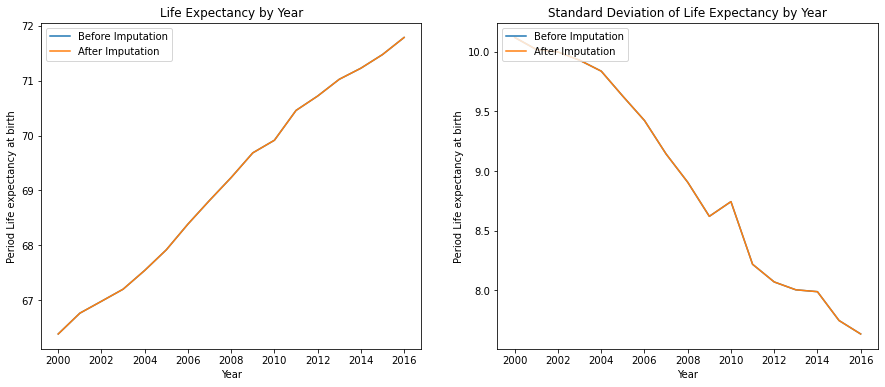

In [18]:
graph_attributes('life_expectancy', 'Period Life expectancy at birth', 'Life Expectancy by Year', \
                 'Standard Deviation of Life Expectancy by Year')

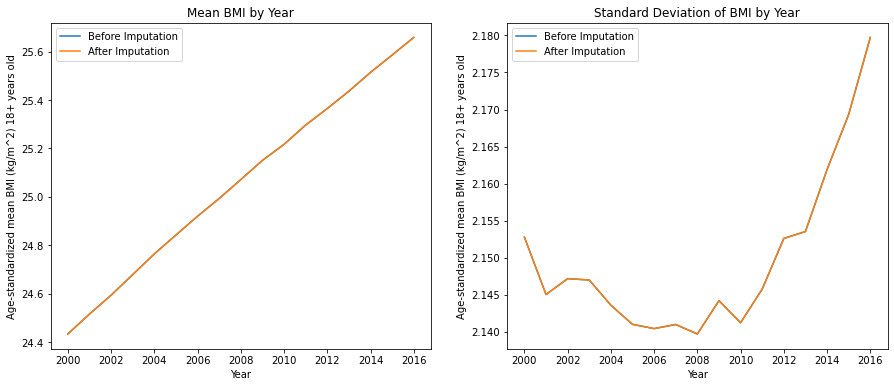

In [19]:
graph_attributes('bmi', 'Age-standardized mean BMI (kg/m^2) 18+ years old', 'Mean BMI by Year', \
                 'Standard Deviation of BMI by Year')

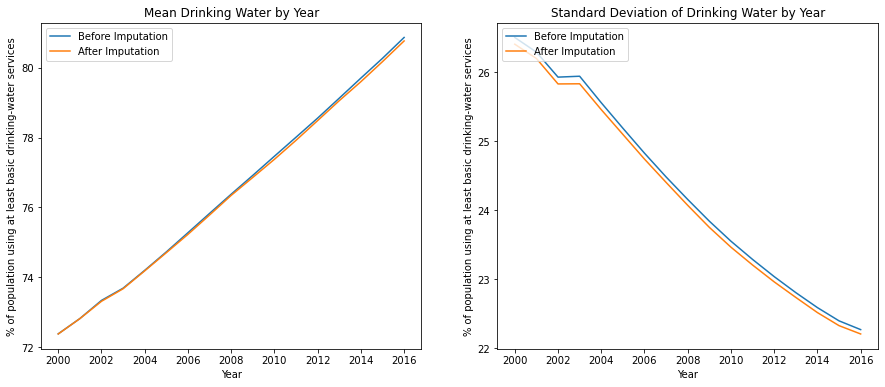

In [20]:
graph_attributes('drinking_water', '% of population using at least basic drinking-water services', \
                 'Mean Drinking Water by Year', 'Standard Deviation of Drinking Water by Year')

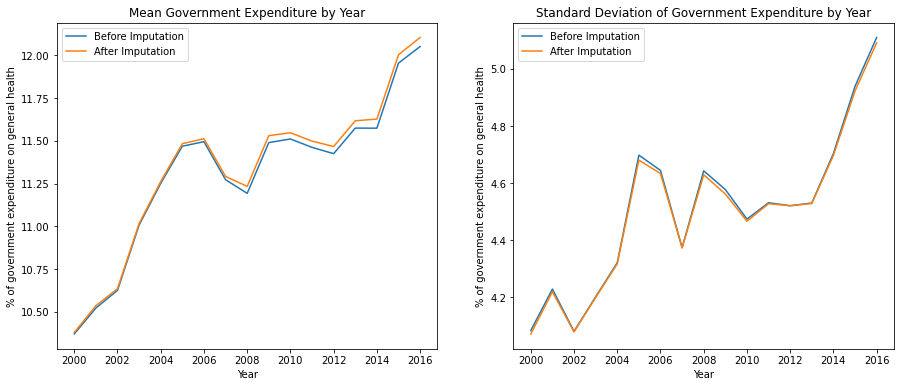

In [21]:
graph_attributes('government_expenditure', '% of government expenditure on general health', \
                 'Mean Government Expenditure by Year', 'Standard Deviation of Government Expenditure by Year')

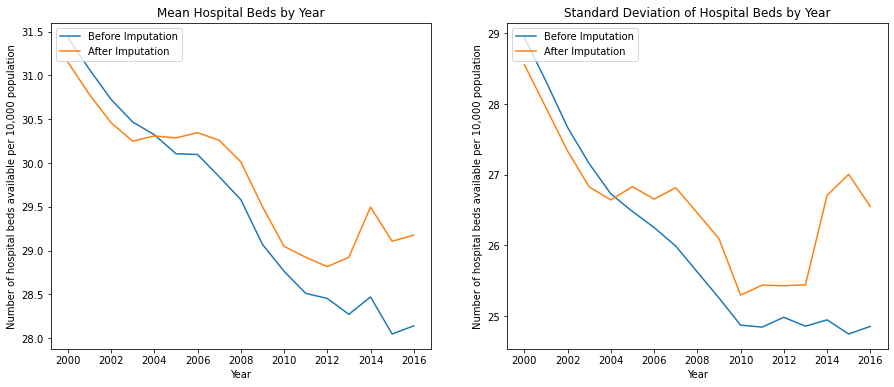

In [22]:
graph_attributes('hospital_beds', 'Number of hospital beds available per 10,000 population', 'Mean Hospital Beds by Year', \
                 'Standard Deviation of Hospital Beds by Year')

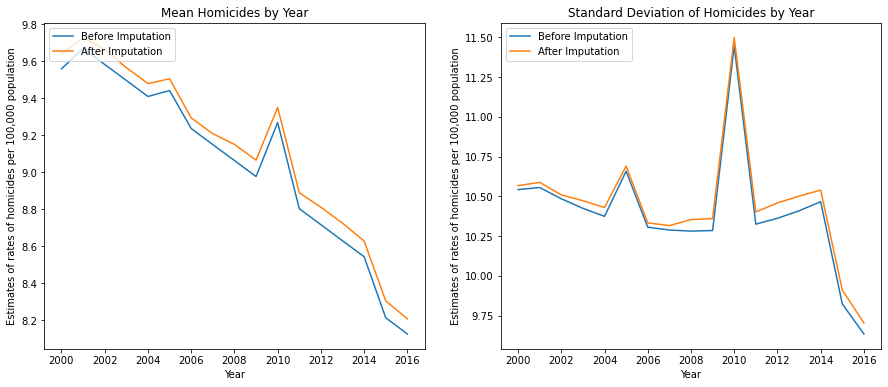

In [23]:
graph_attributes('homicides', 'Estimates of rates of homicides per 100,000 population', 'Mean Homicides by Year', \
                 'Standard Deviation of Homicides by Year')

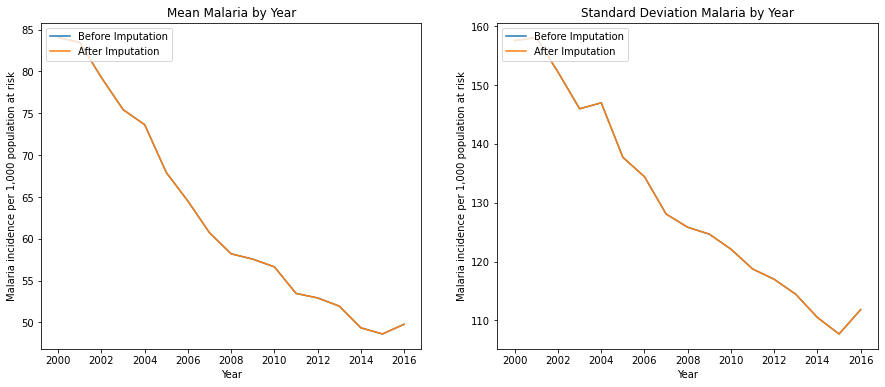

In [24]:
graph_attributes('malaria', 'Malaria incidence per 1,000 population at risk', 'Mean Malaria by Year', \
                 'Standard Deviation Malaria by Year')

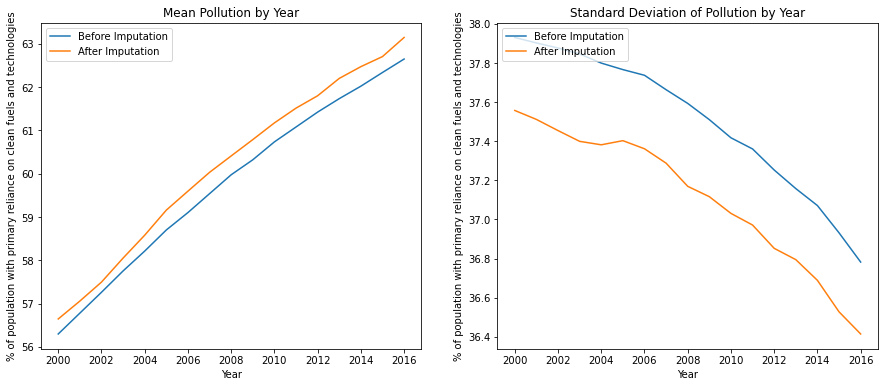

In [25]:
graph_attributes('pollution', '% of population with primary reliance on clean fuels and technologies', \
                 'Mean Pollution by Year', 'Standard Deviation of Pollution by Year')

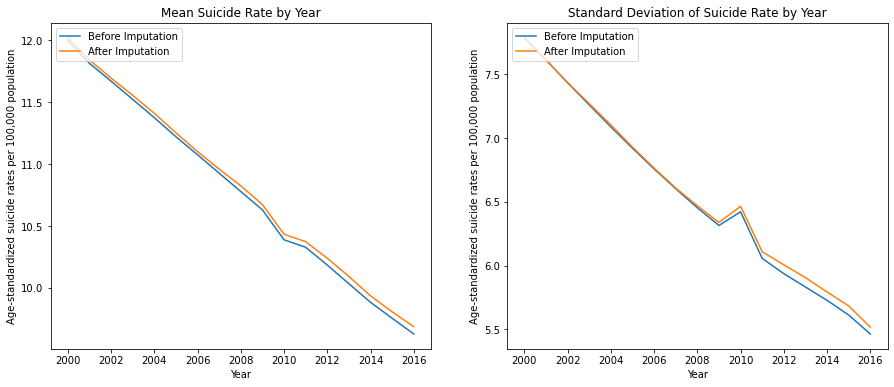

In [26]:
graph_attributes('suicides', 'Age-standardized suicide rates per 100,000 population', 'Mean Suicide Rate by Year', \
                 'Standard Deviation of Suicide Rate by Year')

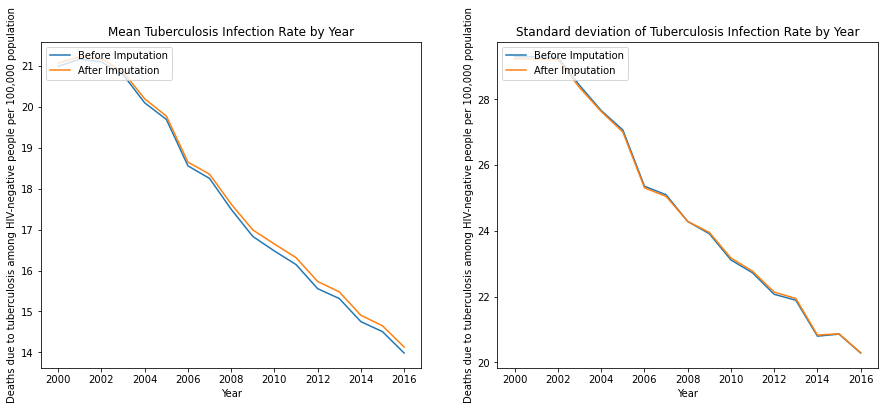

In [27]:
graph_attributes('tuberculosis', 'Deaths due to tuberculosis among HIV-negative people per 100,000 population', \
                 'Mean Tuberculosis Infection Rate by Year', 'Standard deviation of Tuberculosis Infection Rate by Year')

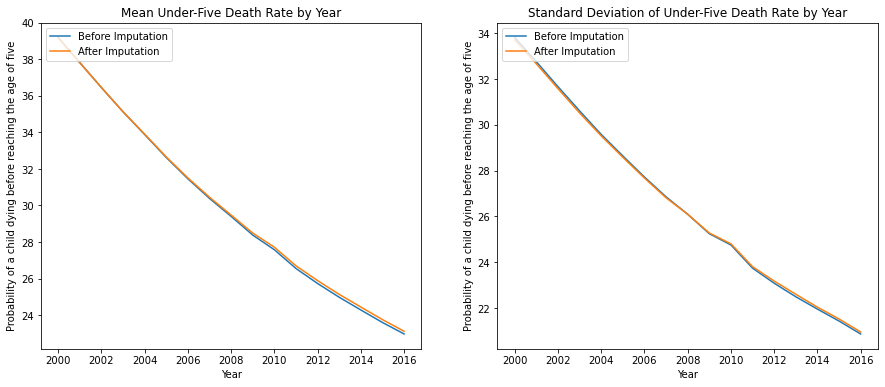

In [28]:
graph_attributes('under_five_deaths', 'Probability of a child dying before reaching the age of five', \
                 'Mean Under-Five Death Rate by Year', 'Standard Deviation of Under-Five Death Rate by Year')

The 22 graphs above show that our imputation didn't introduce a huge bias. The biggest mean and standard deviation changes occured for the data on hospital beds and pollution, which, unsuprisingly, were the two features with the most missing data. It is important that we keep an eye on these two features as we move on.

Now that we have an idea of how each feature is changing over time, lets look at the mean and standard deviation of life expectancy for each country over the 17 year time period. The bar graph below does this, ordering the countries by mean life expectancy.

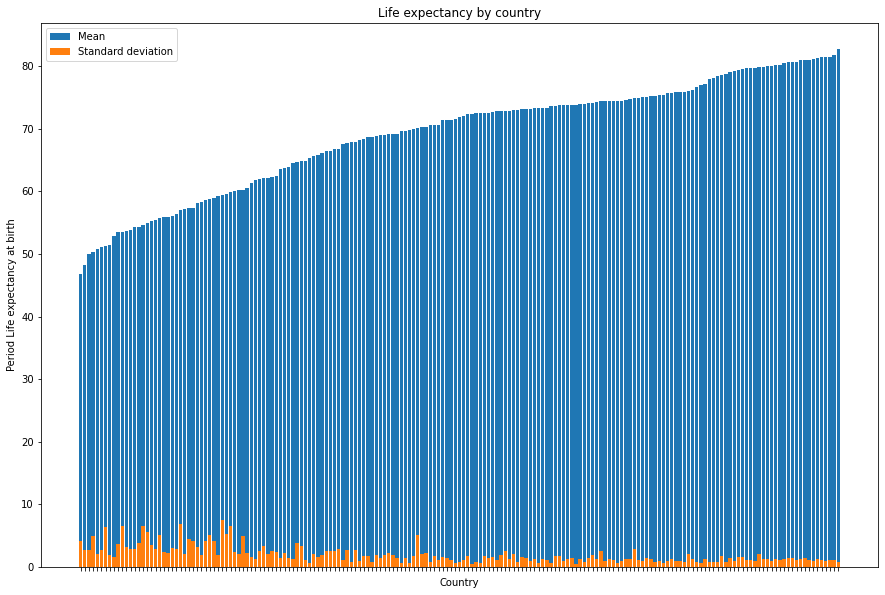

In [29]:
# labels the x and y axes and sets the size of the plot
plt.figure(figsize=(15, 10))
plt.title('Life expectancy by country')
plt.xlabel('Country')
plt.ylabel('Period Life expectancy at birth')

# creates a dataset that computes the mean and standard deviation of the life expectancy for each country
# and merges the two values into one table
life_exp_mean = df.groupby('country', as_index=False)['life_expectancy'].mean()
life_exp_std = df.groupby('country', as_index=False)['life_expectancy'].std()
life_exp = life_exp_mean.merge(life_exp_std, how="outer", left_on = ["country"],  right_on = ["country"])

# renames columns to have more convenient names
life_exp = life_exp.rename(columns={"life_expectancy_x": "mean", "life_expectancy_y": "stdev"})

# sorts based on mean
life_exp.sort_values('mean', inplace=True)

# plots the bar graph shown below
plt.bar(x=life_exp['country'], height=life_exp['mean'], tick_label='')
plt.bar(x=life_exp['country'], height=life_exp['stdev'], tick_label='')

# creates the legend that shows mean and standard deviation by color
plt.legend(['Mean', 'Standard deviation'], loc='upper left')

plt.show()

This chart shows us that countries differ greatly with regards to mean life expectancy. There are too many countries in the table to show which bar corresponds to which country, but the pattern is there. The country with the highest mean life expectancy is almost twice as much as the country with the lowest mean life expectancy. Also, the stardard deviation of life expectancies within the 17 year period is much higher in countries with lower mean life expectancies. Hopefully this means that the life expectancy is just increasing faster in those countries.

## Hypothesis Testing and Feature Importance
Let's now create a linear regression model to predict life expectancy using all of our data. Before using it, we should test it using a z-test to make sure we are making accurate predictions. To learn more about how we implemented this test, look <a href="https://www.statsmodels.org/devel/example_formulas.html">here</a>.

In [30]:
# get the features and the life expectancy data
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)

# the formula uses life expectancy as the independent variable and all the features as independent variables
formula = "life_expectancy ~ year + bmi + drinking_water + government_expenditure + hospital_beds + homicides + malaria + \
         pollution + suicides + tuberculosis + under_five_deaths"
reg = smf.ols(formula=formula, data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2479.
Date:                Sat, 19 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:38:26   Log-Likelihood:                -7743.4
No. Observations:                3111   AIC:                         1.551e+04
Df Residuals:                    3099   BIC:                         1.558e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -62.8837     22.522     -2.792      0.005    -107.043     -18.724
year                       0.0719      0.011      6.398      0.000       0.050       0.094
bmi                       -0.3830      0.035    -10.805      0.000      -0.453      -0.314
drinking_water             0.0414      0.004      9.357      0.000       0.033       0.050
government_expenditure     0.1522      0.013     11.881      0.000       0.127       0.177
hospital_beds             -0.0003      0.003     -0.124      0.902      -0.006       0.005
homicides                 -0.0795      0.006    -14.407      0.000      -0.090      -0.069
malaria                   -0.0042      0.001     -6.859      0.000      -0.005      -0.003
pollution                  0.0362      0.003     13.429      0.000       0.031       0.041
suicides                  -0.1948      0.009    -21.252      0.000      -0.213      -0.177
tuberculosis              -0.0269      0.003     -8.489      0.000      -0.033      -0.021
under_five_deaths         -0.2048      0.005    -42.607      0.000      -0.214      -0.195
==============================================================================
Omnibus:                      939.924   Durbin-Watson:                   0.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4595.108
Skew:                          -1.365   Prob(JB):                         0.00
Kurtosis:                       8.291   Cond. No.                     8.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The probability of the F-statistic is very close to 0, so compared to any resonable alpha, it is highly unlikely that the null hypothesis of no relationship between our features and life expectancy is true. Therefore, we should feel comfortable with using linear regression to make predictions. Let's now create a model using sklearn's linear regression library. After training, we can graph the coefficients for each of the 11 features (including year) to see how they are impacting the final prediction.

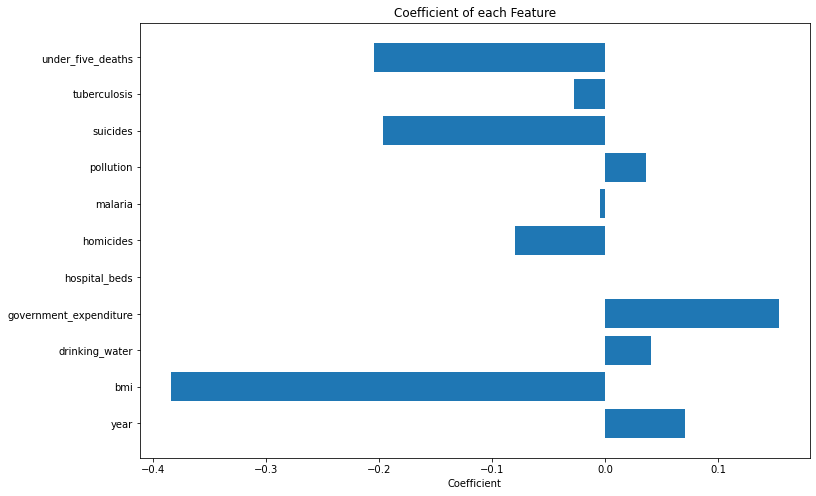

In [31]:
# use linear regression to fit the data
reg = LinearRegression().fit(X, y)

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=df.columns[1:-1], width=reg.coef_)
plt.show()

The chart above shows that some of the features have a negative correlation to life expectancy and some of the features have a positive correlation to life expectancy. This data mostly makes sense. For example, homicides should be negatively correlated with life expectancy and government expenditure should be positively correlated with life expectancy. The only outlier is pollution, where it looks like it is actually helping to increase life expectancy. Of course, this does not make much sense, so this will have to be addressed later.

To further analyze the data, we can find the importance for each feature. Feature importances show how useful each feature is in making a model accurate. The bar graph below plots feature importance based on a random forest classifier. We found that 100 estimators works great, and the gini measure is faster than the entropy measure with no other noticible differences. The documentation on sklearn's random forest classifier feature importance is <a href="https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html">here</a>. Also, to learn more about what feature importance is and what can be done with it, click <a href="https://medium.com/bigdatarepublic/feature-importance-whats-in-a-name-79532e59eea3">here</a>.

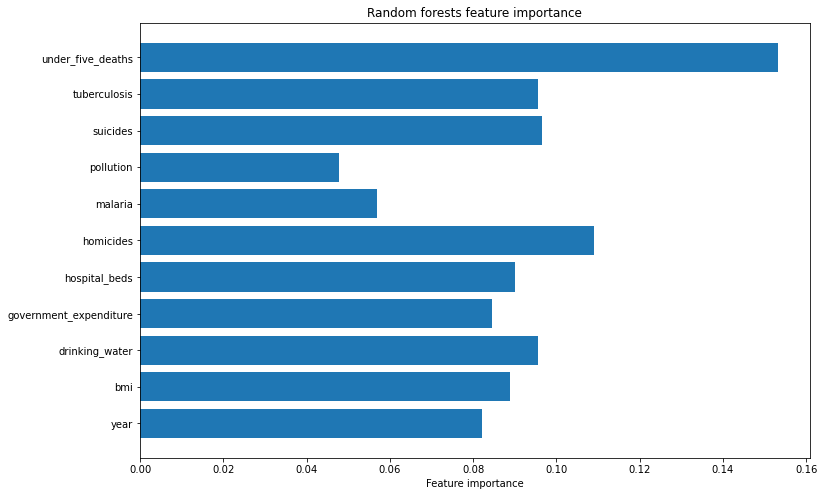

In [32]:
# get the features and the life expectancy data
X = df.values[:, 1:-1]
y = df.values[:, -1].astype(int)

# using random forest classification to get feature importances
clf = RandomForestClassifier(n_estimators=100, criterion="gini")
clf = clf.fit(X, y)

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Random forests feature importance')
plt.xlabel('Feature importance')

# create horizontal bar graph with features on the y-axis and the importance of each feature as the width
plt.barh(y=df.columns[1:-1], width=clf.feature_importances_)
plt.show()

From the chart above, under-five deaths is clearly the best feature for predicting while both pollution and malaria are the least important features for predicting. It's important to note that this plot generates these values based on the whole dataset, so it may be more accurate to find the importances for each country individually and then graph the mean of between the countries.

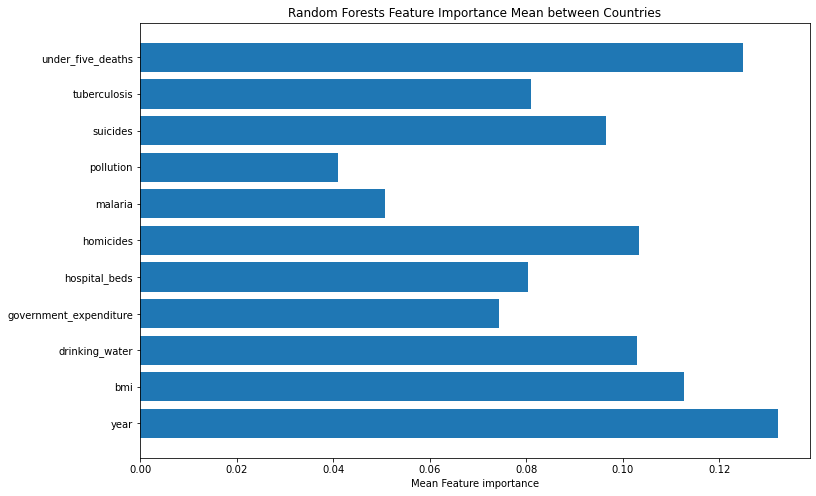

In [33]:
# generate an empty 2D numpy array for every country (183 of them) with space for every feature and the name of the
# country (11 total)
importances = np.empty((183, 11))
i = 0

# iterates through every country once
for country in df['country'].unique():
    
    # get the features and the life expectancy data for the country for all 17 years
    X = df[df['country'] == country].values[:, 1:-1]
    y = df[df['country'] == country].values[:, -1].astype(int)
    
    # using random forest classification to get feature importances
    clf = RandomForestClassifier(n_estimators=100, criterion="gini")
    clf = clf.fit(X, y)
    
    # put the importance of each of this country's features into a row of the 2D numpy array
    importances[i] = clf.feature_importances_
    i += 1

# used for calculating the mean importance for every feature
mean_importances = []

# Runs 11 times, once for every feature, and calculates the mean
for i in range(11):
    mean_importances.append(importances[:, i].mean())

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Random Forests Feature Importance Mean between Countries')
plt.xlabel('Mean Feature importance')

# create horizontal bar graph with features on the y-axis and the importance of each feature as the width
plt.barh(y=df.columns[1:-1], width=mean_importances)
plt.show()

This actually yields some major differences compared to the previous plot. The two features, year and under five deaths, are close in terms of their feature importance value whereas they were not close at all in the previous bar graph. Pollution and malaria are still the worst at predicting for the model, but this could be because many of the countries in the dataset do not have a malaria problem. To check this, we should generate a plot that excludes countries that don't have any issues with malaria.

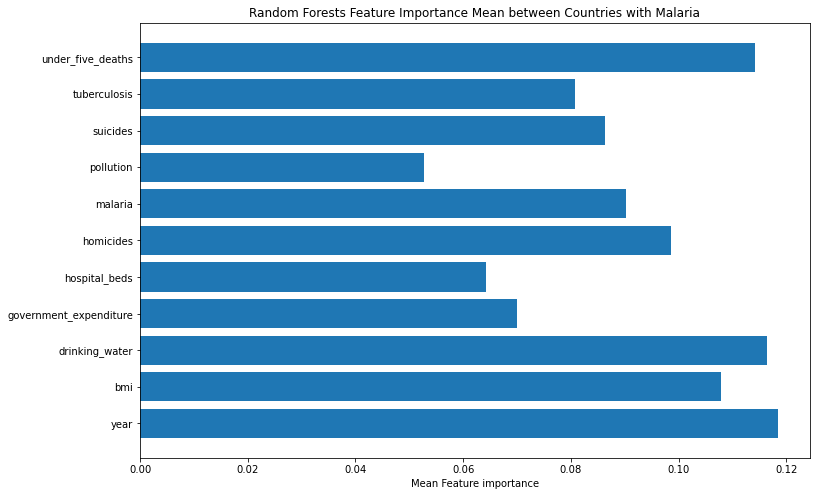

In [34]:
# create a new dataset that stores the importance of every country's features
importances_df = pd.DataFrame(importances)
importances_df.insert(0, "country", df["country"].unique(), True)
importances_df.columns = ['country', 'year', 'bmi', 'drinking_water', 'government_expenditure', 'hospital_beds', \
                          'homicides', 'malaria', 'pollution', 'suicides', 'tuberculosis', 'under_five_deaths']

# makes a copy of the dataframe so that is can be used later
importances_dfcopy = importances_df.copy()

# gets the list of countries that do not have 0 as their malaria entries for any year
malaria_not0 = df.loc[df['malaria'] != 0]['country'].unique()
importances_df = importances_df[importances_df.country.isin(malaria_not0)]

# remove the column that specifies country and turn it into a numpy array storing only numbers
importances_df.drop('country',axis=1,inplace=True)
importances_numpy = importances_df.to_numpy()

# used for calculating the mean importance for every feature
mean_importances2 = []

# Runs 11 times, once for every feature, and calculates the mean
for i in range(11):
    mean_importances2.append(importances_numpy[:, i].mean())

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Random Forests Feature Importance Mean between Countries with Malaria')
plt.xlabel('Mean Feature importance')

# create horizontal bar graph with features on the y-axis and the mean importance of each feature as the width
plt.barh(y=df.columns[1:-1], width=mean_importances2)
plt.show()

When we removed the countries without malaria, it certainly caused malaria to have more of an impact on the model. However, this is not going to yield the best predictor when generalizing to every country. This will disproportionally affect countries that have malaria outbreaks compared to countries that do not. Therefore, we will go back to using the dataset that includes every country.

To further understand the importance of each feature, we will look at how many countries have each feature as their most important one. The cell below plots a graph that counts exactly this. This shows that each feature may affect each country in a different way.

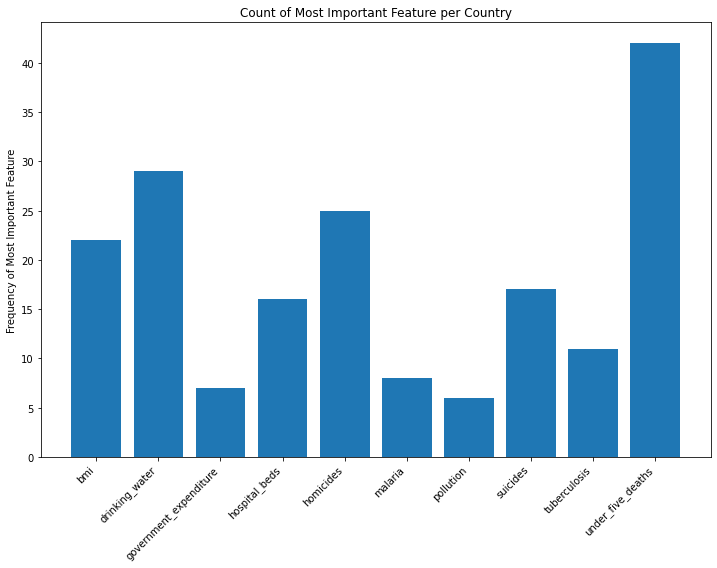

In [35]:
# get the old dataset back (before removing countries with 0 cases of malaria) and drop the country and year, as
# the country isn't a feature and the year being a countries "most important" feature doesn't make much sense
importances_df = importances_dfcopy.copy()
importances_df.drop('country',axis=1,inplace=True)
importances_df.drop('year',axis=1,inplace=True)

# create a numpy array of zeros for the 10 features used in the plot
feature_counts = np.zeros(10)

# get a count of every country's most important feature and put it into the respective slot in feature_counts
for index, row in importances_df.iterrows():
    feature_counts[importances_df.columns.get_loc(row.idxmax())] += 1

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Count of Most Important Feature per Country')
plt.ylabel('Frequency of Most Important Feature')

# create horizontal bar graph with features (without year) on the y-axis and the importance of each feature as the width
plt.bar(x=df.columns[2:-1], height=feature_counts)
plt.xticks(rotation=45, ha="right")
plt.show()

Just as before, under five deaths is the best predictor for the highest number of countries. Malaria and pollution are still not that great predicting. For explanatory purposes, below we create a table that shows every country's feature importance in order of most important to least important.

In [36]:
# create a new empty dataframe
df_by_country = pd.DataFrame()

# iterate through every row of the importances dataframe
for index, row in importances_df.iterrows():
    
    # temp stores the country name as a list
    temp = [importances_dfcopy.loc[index, 'country']]
    
    # temp gets the features in order of feature importance, greatest to least
    temp.extend(row.sort_values(ascending=False).index)
    
    # appends the dataframe with this country's feature importance list in order
    df_by_country = df_by_country.append([temp], ignore_index=True)

# renames the columns
df_by_country.columns = ['country', '1st important feature', '2nd important feature', '3rd important feature', \
                         '4th important feature', '5th important feature', '6th important feature', '7th important feature', \
                         '8th important feature', '9th important feature', '10th important feature']

df_by_country.head()

,country,1st important feature,2nd important feature,3rd important feature,4th important feature,5th important feature,6th important feature,7th important feature,8th important feature,9th important feature,10th important feature
0,Afghanistan,bmi,suicides,drinking_water,under_five_deaths,homicides,malaria,pollution,tuberculosis,government_expenditure,hospital_beds
1,Albania,homicides,under_five_deaths,pollution,bmi,drinking_water,government_expenditure,hospital_beds,suicides,tuberculosis,malaria
2,Algeria,under_five_deaths,drinking_water,hospital_beds,government_expenditure,homicides,suicides,bmi,tuberculosis,malaria,pollution
3,Angola,bmi,government_expenditure,under_five_deaths,drinking_water,malaria,tuberculosis,suicides,homicides,pollution,hospital_beds
4,Antigua and Barbuda,hospital_beds,under_five_deaths,suicides,bmi,government_expenditure,drinking_water,homicides,tuberculosis,pollution,malaria


We can plot the most important feature for each country in a map. The JSON file includes locations for every country so that they can be plotted on the map, which is used from the Plotly library using the choropleth method. Every country's most important feature is used and the country is color coded as based on it. The documentation for making maps like this in plotly can be found <a href="https://plotly.com/python/choropleth-maps/">here</a>. Additionally, the geospacial data we used to mark the countries can be found <a href="https://www.kaggle.com/chapagain/country-state-geo-location">here</a>.

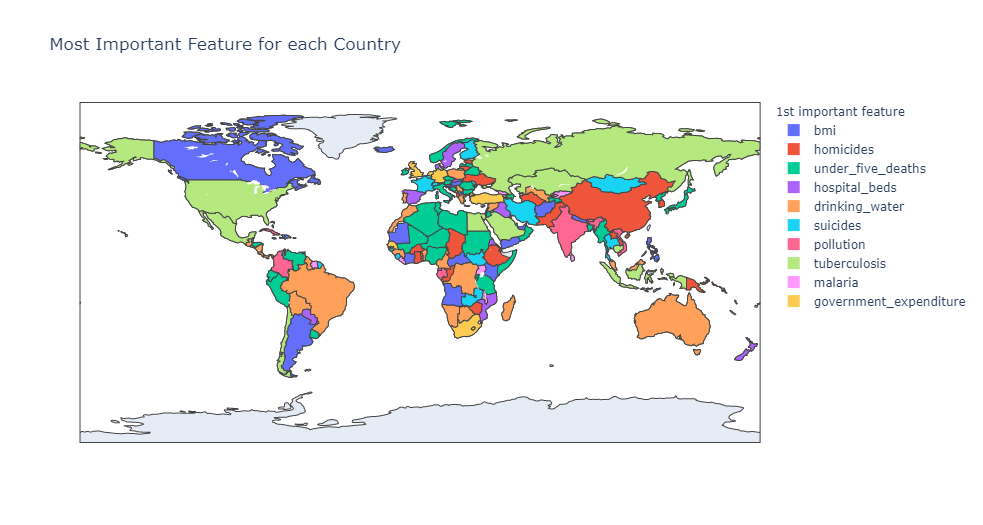

In [43]:
# read in the geospacial data
wc = r'countries.geo.json'

fig = px.choropleth(df_by_country, geojson=wc, color="1st important feature", locations="country", \
                    locationmode = 'country names', featureidkey="feature.properties.name", \
                    title="Most Important Feature for each Country")

# the image does not correctly show on the HTML, so instead a screenshot was taken of it and is shown below
Image(filename = "feature_importance.png")

# this would show the interactive map as it does in the notebook
# fig.show()

## Individual Country Analysis

We found several times that malaria and pollution are the worst at predicting our model. Therefore, our model could potentially be a better predictor by removing those two features. Let's see what happens when we do this and create another linear model.

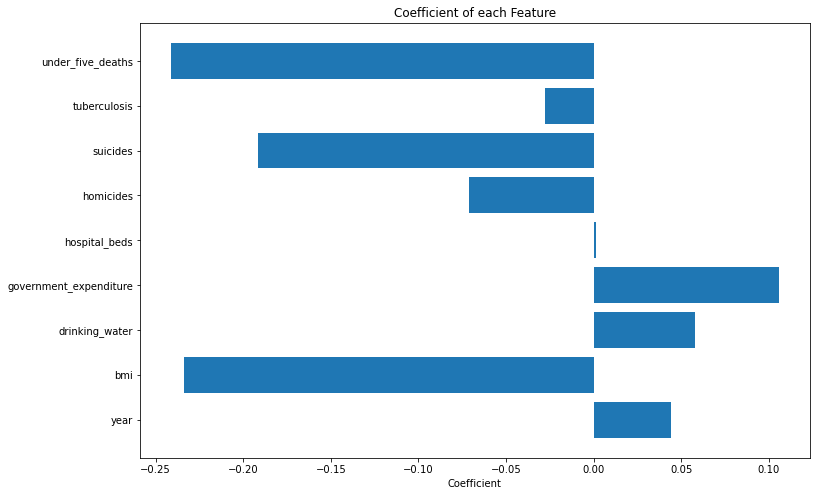

In [38]:
# create a copy of the original dataframe without pollution and malaria
df2 = df.copy()
df2.drop('pollution',axis=1,inplace=True)
df2.drop('malaria',axis=1,inplace=True)

# get the features and the life expectancy data
X = df2.values[:, 1:-1]
y = df2.values[:, -1].astype(int)

# creating the linear regression line
reg = LinearRegression().fit(X, y)

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Coefficient of each Feature')
plt.xlabel('Coefficient')

# create horizontal bar graph with features on the y-axis and the coefficient of each feature as the width
plt.barh(y=df2.columns[1:-1], width=reg.coef_)
plt.show()

Now we can see the predictors that positively and negatively affect life expectancy. Under five deaths, tuberculosis, suicides, homicides, and BMI are all negative factors while hospital beds, government expenditure, drinking water, and year are all positive factors. There are 5 negative factors and 4 positive factors.

Now that we know which features are the most important, we will standardize the feature data so we can continue processing with it. This is done using Scikit-Learn. The documentation for this can be found <a href="https://scikit-learn.org/stable/modules/preprocessing.html">here</a>.

In [39]:
# create a new dataframe that has every feature, aside from year, standardized
df2standardized = df2.copy() 

# iterate through every column that is a feature and put the standardized numbers back into the dataset
for column in df2standardized.columns[2:-1]:
    x_array = np.array(df2standardized[column])
    X_scaled = preprocessing.scale(x_array)
    df2standardized[column] = X_scaled
    
df2standardized.head()

,country,year,bmi,drinking_water,government_expenditure,hospital_beds,homicides,suicides,tuberculosis,under_five_deaths,life_expectancy
0,Afghanistan,2016,-0.763351,-0.886876,0.436305,-0.934968,-0.165860,-0.666086,0.644818,0.779566,62.7
1,Afghanistan,2015,-0.809303,-0.987706,0.312408,-0.934968,-0.165860,-0.635928,0.844693,0.847546,63.2
2,Afghanistan,2014,-0.855255,-1.087713,0.146474,-0.934968,-0.132324,-0.620850,1.004592,0.920671,63.0
3,Afghanistan,2013,-0.947158,-1.186485,-0.165482,-0.923665,-0.130408,-0.605771,1.004592,0.996735,62.7
4,Afghanistan,2012,-0.993110,-1.284023,0.073463,-0.923665,-0.127533,-0.590692,1.044567,1.078311,62.2


Our end goal is to figure out which feature every country needs to prioritize to improve their life expectancy. To do this, we must calculate the average values for every feature to see how every country compares with it. Since a feature can be positive or negative, it's important to outline the difference.

1) If the feature is a positive feature (like government expenditure), a country wants a higher number for this.

2) If the feature is a negative feature (like homicides), a country wants a lower number for this.

<br><br>
This is important when computing the average value between every country. Depending on the feature, a country may want to increase their number in one category and decrease their number in another. There are multiple possibilities for this.

1) The feature is positive and the country is lower than the mean. This means they should focus more on improving this.

2) The feature is positive and the country is higher than the mean. This means they should not need to focus as much on this.

3) The feature is negative and the country is lower than the mean. This means they should not need to focus as much on this.

4) The feature is negative and the country is higher than they mean. This means they should focus more on improving this.

<br><br>
We want to focus on the features that countries should improve on. It is important to figure out where each one falls from the four options above, which is what the code below does. It compares the country's features to the mean and figures out if it needs to be improved. If it does, it is stored as some positive number, and if not, it is a negative number. The highest number out of all the features is the one that the country should improve on the most.

In [40]:
# create a new empty dataframe
df_priorities = pd.DataFrame()

# calculate the average values of the standardized features
avg_values = df2standardized.mean().values
avg_values

# the mask is what separates the positive features from the negative features, where if it is -1, the corresponding
# feature is positive and if it is 1, the corresponding feature is negative
mask = [1, -1, -1, -1, 1, 1, 1, 1]

# iterate through every country
for country in df2standardized['country'].unique():
    
    # this stores the country's standardized features by computing the average among all 17 years
    country_averages = df2standardized.loc[df2standardized['country'] == country].groupby('country', as_index=False).mean()
    
    # calculates the difference between this country's values and the average values, and multiplies it with the mask
    # to get the feature that needs to be prioritized the most
    difference_to_avg = country_averages.values[0, 2:-1] - avg_values[1:-1]
    difference_to_avg *= mask
    
    # put this country's feature that needs to be prioritized the most into the dataframe
    df_priorities = df_priorities.append([[country, df2standardized.columns[difference_to_avg.argmax() + 2]]], \
                                         ignore_index=True)

# rename the columns
df_priorities.columns = ['country', 'feature_to_improve']
df_priorities.head()

,country,feature_to_improve
0,Afghanistan,drinking_water
1,Albania,government_expenditure
2,Algeria,government_expenditure
3,Angola,drinking_water
4,Antigua and Barbuda,bmi


Now we can sum the number of countries that have each feature as its number one priority. This is calculated and plotted below.

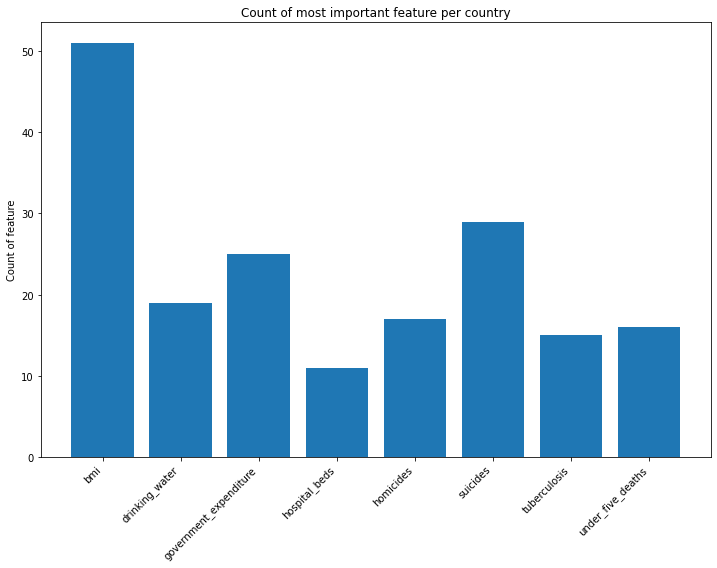

In [41]:
# create an array of zeros for the eight features that are used for prioritizing (year is excluded because it doesn't
# make sense for a country to prioritize a year)
feature_counts = np.zeros(8)

# gets the column names of the eight features
country_averages.columns[2:-1]

# iterates through every country in the priorities dataframe and adds one to the feature that needs to be prioritized
# into the numpy array feature_counts
for index, row in df_priorities.iterrows():
    feature_counts[country_averages.columns[2:-1].get_loc(row['feature_to_improve'])] += 1

# set plot size and labels
plt.figure(figsize=(12, 8))
plt.title('Count of most important feature per country')
plt.ylabel('Count of feature')

# create bar graph with features on the x-axis and the count of how many countries needs to prioritize the feature
# the most height
plt.bar(x=country_averages.columns[2:-1], height=feature_counts)
plt.xticks(rotation=45, ha="right")
plt.show()

We can see that most countries need to prioritize lowering their average BMI in order to raise their life expectancy. This is interesting to see, because now we can understand that tackling issues like obesity can help the most countries improve their life expectancy. For further visualization, a map is shown below that color codes every country based on the feature they need to improve the most.

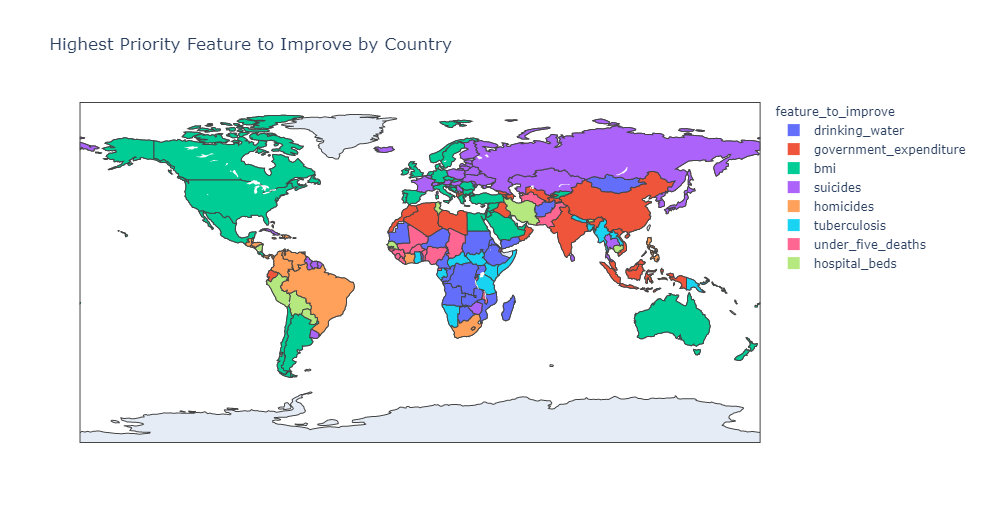

In [44]:
# read in the geospacial data
wc = r'countries.geo.json'

fig = px.choropleth(df_priorities, geojson=wc, color="feature_to_improve", locations="country", \
                    locationmode = 'country names', featureidkey="feature.properties.name", \
                    title="Highest Priority Feature to Improve by Country")

# the image does not correctly show on the HTML, so instead a screenshot was taken of it and is shown below
Image(filename = "priority_features.png")

# this would show the interactive map as it does in the notebook
# fig.show()

## Insight and Conclusion

Looking at the map, the features are generally grouped together for neighboring countries. This already makes it more promising as a useful tool than the map of feature
importances we made earlier. To test this data, we need to consult some outside sources. Worldvision.org published a <a href="https://www.worldvision.org/clean-water-news-stories/10-worst-countries-access-clean-water">list</a> of the 10 countries with the worst access to 
drinking water, and of those 10 countries, our model recommended that 7 of them should put clean drinking water as their primary focus. Additionally, for the 20 countries with
the highest suicide mortality rates, our model predicted that 17 of them should primarily focus on suicides (<a href="https://www.statista.com/statistics/710710/ranking-of-leading-20-countries-with-highest-suicide-mortality-rates/">statista</a>). Consequently, comparing our data with these sources suggests that
our model can be useful for analyzing which feature should be prioritized the most. 

It is also important to note that there are much more than ten features that should be considered when working to increase global health. This tutorial is a simplification of the issues
at hand, and the predictions are not made to be followed blindly, but rather they are made so that we can have a better understanding of the kinds of factors limiting an increase in global health.
By nature, the issue of global health is massive, so solving it requires it to be broken up substantially. With this tutorial, our goal was to begin breaking up this problem, while at the same time providing an educational data science tool to all those who read it.

We hope you learned something by reading this tutorial. For more resources and data on global health, visit the <a href="https://www.who.int/data/gho">Global Health Observatory page</a> by the World Health Organization. There you can find data on almost anything related to global heatlh.
